In [1]:
import argparse
import math
from typing import List, Optional

import torch
from torch.cuda.amp import GradScaler
from torch.distributed.elastic.multiprocessing import errors

from common import (
    DEFAULT_EPOCHS,
    DEFAULT_ITERATIONS,
    DEFAULT_MAX_EPOCHS,
    DEFAULT_MAX_ITERATIONS,
)
from cvnets import EMA, get_model
from data import create_train_val_loader
from engine import Trainer
from loss_fn import build_loss_fn
from optim import build_optimizer
from optim.scheduler import build_scheduler
from options.opts import get_training_arguments
from utils import logger, resources
from utils.checkpoint_utils import load_checkpoint, load_model_state
from utils.common_utils import create_directories, device_setup
from utils.ddp_utils import distributed_init, is_master


[2025-02-09 14:24:32,689] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
# set-up data loaders
args = ["--common.config-file", "config/segmentation/ade20k/deeplabv3_mobilevitv2.yaml", "--common.results-loc", "deeplabv3_mobilevitv2_results/exp"]
opts = get_training_arguments(args=args)
setattr(opts, "ddp.use_distributed", False)

print(opts)
train_loader, val_loader, train_sampler = create_train_val_loader(opts)

2025-02-09 14:24:33 - DEBUG    - Cannot load internal arguments, skipping.
Namespace(taskname='+ MobileViTv2-1.0 DeepLabv3', **{'dataset.root_train': './vision_datasets/ADEChallengeData2016/', 'dataset.root_val': './vision_datasets/ADEChallengeData2016/', 'dataset.root_test': '', 'dataset.disable_val': False, 'dataset.name': 'ade20k', 'dataset.category': 'segmentation', 'dataset.percentage_of_samples': 100.0, 'dataset.sample_selection_random_seed': 0, 'dataset.train_batch_size0': 4, 'dataset.val_batch_size0': 4, 'dataset.eval_batch_size0': 1, 'dataset.workers': 4, 'dataset.persistent_workers': False, 'dataset.pin_memory': False, 'dataset.prefetch_factor': 2, 'dataset.padding_index': None, 'dataset.text_vocab_size': -1, 'dataset.text_context_length': None, 'evaluation.segmentation.apply_color_map': False, 'evaluation.segmentation.save_overlay_rgb_pred': False, 'evaluation.segmentation.save_masks': False, 'evaluation.segmentation.overlay_mask_weight': 0.5, 'evaluation.segmentation.mode':

In [3]:
model = get_model(opts)

2025-02-09 14:25:01 - LOGS    - Pretrained weights are loaded from /tmp/cvnets/mobilevitv2-1.0.pt
2025-02-09 14:25:01 - INFO    - Trainable parameters: ['conv_1.block.conv.weight', 'conv_1.block.norm.weight', 'conv_1.block.norm.bias', 'layer_1.0.block.exp_1x1.block.conv.weight', 'layer_1.0.block.exp_1x1.block.norm.weight', 'layer_1.0.block.exp_1x1.block.norm.bias', 'layer_1.0.block.conv_3x3.block.conv.weight', 'layer_1.0.block.conv_3x3.block.norm.weight', 'layer_1.0.block.conv_3x3.block.norm.bias', 'layer_1.0.block.red_1x1.block.conv.weight', 'layer_1.0.block.red_1x1.block.norm.weight', 'layer_1.0.block.red_1x1.block.norm.bias', 'layer_2.0.block.exp_1x1.block.conv.weight', 'layer_2.0.block.exp_1x1.block.norm.weight', 'layer_2.0.block.exp_1x1.block.norm.bias', 'layer_2.0.block.conv_3x3.block.conv.weight', 'layer_2.0.block.conv_3x3.block.norm.weight', 'layer_2.0.block.conv_3x3.block.norm.bias', 'layer_2.0.block.red_1x1.block.conv.weight', 'layer_2.0.block.red_1x1.block.norm.weight', 'lay

In [7]:
# for batch_id, batch in enumerate(train_loader):
    # print(batch_id)

count = sum(1 for _ in enumerate(train_loader))


In [8]:
count

5053

In [4]:
device = getattr(opts, "dev.device", torch.device("mps"))

criteria = build_loss_fn(opts)

criteria.to(device=device)
model.to(device=device)

SegEncoderDecoder(
  (encoder): MobileViTv2(
    (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=BatchNorm2d, activation=Swish)
    (layer_1): Sequential(
      (0): InvertedResidual(in_channels=32, out_channels=64, stride=1, exp=2, dilation=1, skip_conn=False)
    )
    (layer_2): Sequential(
      (0): InvertedResidual(in_channels=64, out_channels=128, stride=2, exp=2, dilation=1, skip_conn=False)
      (1): InvertedResidual(in_channels=128, out_channels=128, stride=1, exp=2, dilation=1, skip_conn=True)
    )
    (layer_3): Sequential(
      (0): InvertedResidual(in_channels=128, out_channels=256, stride=2, exp=2, dilation=1, skip_conn=False)
      (1): MobileViTBlockv2(
      	 Local representations
      		 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=False, normalization=BatchNorm2d, activation=Swish)
      		 Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      	 Global r

In [5]:
criteria

SegCrossEntropy(
	 ignore_idx=-1
	 class_weighting=False
	 label_smoothing=0.0
	 aux_weight=0.4
)

In [63]:
from typing import Dict, Union

from torch import Tensor
from data.transforms.image_torch import apply_mixing_transforms
from utils.common_utils import move_to_device

model.eval()
for batch_id, batch in enumerate(train_loader):
    batch = move_to_device(opts=opts, x=batch, device=device)
    batch = apply_mixing_transforms(opts=opts, data=batch)

    samples, targets = batch["samples"], batch["targets"]
    pred_label = model(batch["samples"])
    loss_dict_or_tensor: Union[Dict, Tensor] = criteria(
                    input_sample=samples,
                    prediction=pred_label,
                    target=targets,
    )

    break
    

        #     if self.train_iterations > self.max_iterations:
        #         self.max_iterations_reached = True
        #         return -1, -1

        #     # move to device
        #     batch = move_to_device(opts=self.opts, x=batch, device=self.device)
        #     # apply mix-up transforms if any
        #     batch = apply_mixing_transforms(opts=self.opts, data=batch)

        #     batch_load_toc = time.time() - batch_load_start

        #     samples, targets = batch["samples"], batch["targets"]

        #     batch_size = get_batch_size(samples)

        #     # update the learning rate
        #     self.optimizer = self.scheduler.update_lr(
        #         optimizer=self.optimizer, epoch=epoch, curr_iter=self.train_iterations
        #     )

        #     # adjust bn momentum
        #     if self.adjust_norm_mom is not None:
        #         self.adjust_norm_mom.adjust_momentum(
        #             model=self.model, epoch=epoch, iteration=self.train_iterations
        #         )

        #     with autocast_fn(
        #         enabled=self.mixed_precision_training,
        #         amp_precision=self.mixed_precision_dtype,
        #     ):
        #         # prediction
        #         pred_label = self.model(samples)
        #         # compute loss
        #         loss_dict_or_tensor: Union[Dict, Tensor] = self.criteria(
        #             input_sample=samples,
        #             prediction=pred_label,
        #             target=targets,
        #             epoch=epoch,
        #             iterations=self.train_iterations,
        #         )

        #         if isinstance(loss_dict_or_tensor, Dict):
        #             if "total_loss" not in loss_dict_or_tensor.keys():
        #                 logger.error(
        #                     "total_loss key is required for loss functions that return outputs as dictionary."
        #                 )
        #             loss = loss_dict_or_tensor["total_loss"]
        #         elif isinstance(loss_dict_or_tensor, Tensor):
        #             loss = loss_dict_or_tensor
        #         else:
        #             logger.error("Loss value should be an instance of Tensor or Dict")

        #         if isinstance(loss, torch.Tensor) and torch.isnan(loss):
        #             logger.error("Nan encountered in the loss.")

        #     # perform the backward pass with gradient accumulation [Optional]
        #     self.gradient_scaler.scale(loss).backward()

        #     if (batch_id + 1) % accum_freq == 0:
        #         if max_norm is not None:
        #             # For gradient clipping, unscale the gradients and then clip them
        #             self.gradient_scaler.unscale_(self.optimizer)
        #             torch.nn.utils.clip_grad_norm_(
        #                 self.model.parameters(), max_norm=max_norm
        #             )

        #         if "grad_norm" in self.train_metric_names:
        #             # compute grad_norm for logging purposes.
        #             # We can't use the output of clip_grad_norm_ because it returns the total norm before clipping
        #             grad_norm = self.compute_grad_norm()

        #         # optimizer step
        #         self.gradient_scaler.step(optimizer=self.optimizer)
        #         # update the scale for next batch
        #         self.gradient_scaler.update()
        #         # set the gradient to zero or None
        #         self._zero_grad()

        #         self.train_iterations += 1

        #         if self.model_ema is not None:
        #             self.model_ema.update_parameters(self.model)

        #     train_stats.update(
        #         pred_label=pred_label,
        #         target_label=targets,
        #         extras={"loss": loss_dict_or_tensor, "grad_norm": grad_norm},
        #         batch_time=batch_load_toc,
        #         batch_size=batch_size,
        #     )

        #     # save the checkpoint every N updates
        #     if (
        #         self.save_interval
        #         and (self.train_iterations % self.save_interval_freq) == 0
        #     ):

        #         save_interval_checkpoint(
        #             iterations=self.train_iterations,
        #             epoch=epoch,
        #             model=self.model,
        #             optimizer=self.optimizer,
        #             best_metric=loss.item(),
        #             save_dir=self.save_location,
        #             gradient_scaler=self.gradient_scaler,
        #             model_ema=self.model_ema,
        #         )
        #         logger.info(
        #             "Checkpoints saved after {} updates at: {}".format(
        #                 self.train_iterations, self.save_location
        #             ),
        #             print_line=True,
        #         )

        #     if batch_id % self.log_freq == 0 and self.is_master_node:
        #         lr = self.scheduler.retrieve_lr(self.optimizer)
        #         train_stats.iter_summary(
        #             epoch=epoch,
        #             n_processed_samples=self.train_iterations,
        #             total_samples=self.max_iterations,
        #             learning_rate=lr,
        #             elapsed_time=epoch_start_time,
        #         )

        #     batch_load_start = time.time()

        # avg_loss = train_stats.avg_statistics(
        #     metric_name="loss", sub_metric_name="total_loss"
        # )
        # train_stats.epoch_summary(epoch=epoch, stage="training")
        # avg_ckpt_metric = train_stats.avg_statistics(
        #     metric_name=self.ckpt_metric, sub_metric_name=self.ckpt_submetric
        # )

In [65]:
pred_label.shape

torch.Size([4, 150, 128, 128])

In [7]:
pred_label[1].shape

torch.Size([4, 150, 16, 16])

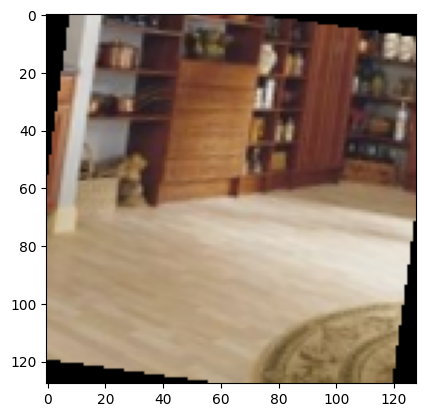

In [8]:
# plot the image and target
import matplotlib.pyplot as plt
import numpy as np


In [67]:
pred_label[0].shape

torch.Size([150, 128, 128])

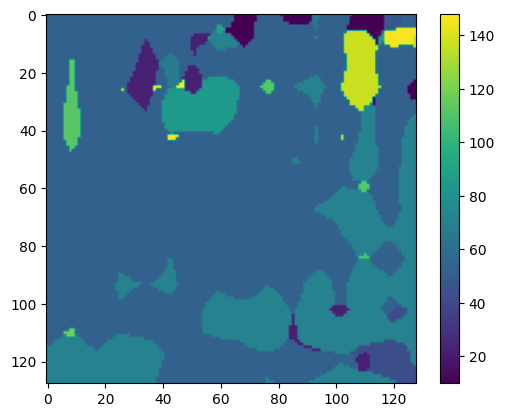

In [75]:
pred_mask = torch.argmax(pred_label[0], dim=0)
plt.imshow(pred_mask.cpu().numpy())
plt.colorbar()

torch.Size([1, 128, 128])

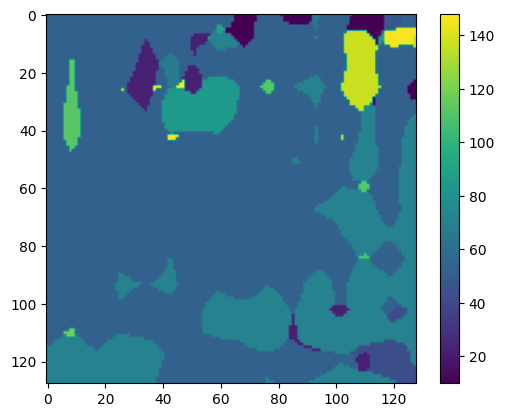

In [76]:
pred_mask = torch.max(pred_label[0], dim=0)[1]

plt.imshow(pred_mask.cpu().numpy())
plt.colorbar()
pred_mask.shape

pred_mask.unsqueeze(0).shape

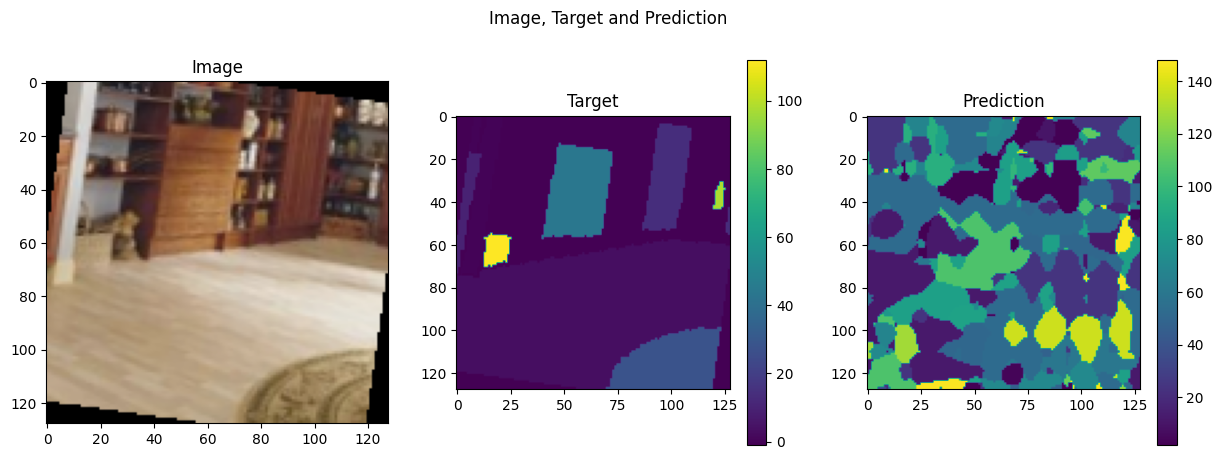

In [32]:
# plt.imshow(np.transpose(samples[1].cpu().numpy(), (1, 2, 0)))
# # plot the target
# plt.imshow(targets[1].cpu().numpy())
# # add the color bar
# plt.colorbar()
# # interactive plot, allow picking the pixel value
# plt.show()
# # plot the prediction
# argmax_pred = torch.argmax(pred_label[0][1], dim=0)
# plt.imshow(argmax_pred.detach().cpu().numpy())
# # add the color bar
# plt.colorbar()
# # interactive plot, allow picking the pixel value

# use subplots to plot the image, target and prediction
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# plot the image
axs[0].imshow(np.transpose(samples[1].cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Image")
# add the color bar
# plot the target
im1 = axs[1].imshow(targets[1].cpu().numpy())
axs[1].set_title("Target")
plt.colorbar(im1, ax=axs[1])
# plot the prediction
argmax_pred = torch.argmax(pred_label[0][1], dim=0)
im2 = axs[2].imshow(argmax_pred.detach().cpu().numpy())
axs[2].set_title("Prediction")
plt.colorbar(im2, ax=axs[2])
# add global title
plt.suptitle("Image, Target and Prediction")

# save as image
plt.savefig("image_target_pred.png")

In [12]:
loss_dict_or_tensor

{'total_loss': tensor(7.1646, device='mps:0', grad_fn=<AddBackward0>),
 'seg_loss': tensor(5.1592, device='mps:0', grad_fn=<NllLoss2DBackward0>),
 'aux_loss': tensor(2.0053, device='mps:0', grad_fn=<MulBackward0>)}

In [18]:
from options.parse_args import parse_validation_metric_names


(
    val_metric_names,
    ckpt_metric,
    ckpt_submetric,
) = parse_validation_metric_names(opts)

train_metric_names = getattr(opts, "stats.train", ["loss"])

In [49]:
val_metric_names

['loss', 'iou']

In [20]:
from engine.utils import get_log_writers
from metrics.stats import Statistics

log_writers = get_log_writers(opts, save_location="./")

validation_stats = Statistics(
        opts=opts,
        metric_names=val_metric_names,
        is_master_node=True,
        is_distributed=False,
        log_writers=log_writers,
    )

In [25]:
validation_stats.update(
    pred_label=pred_label[0],
    target_label=targets,
    extras={"loss": loss_dict_or_tensor},
    batch_time=0,
    batch_size=4,
)

validation_stats.epoch_summary(epoch=1, stage="validation")

2025-02-09 15:05:47 - LOGS    - *** Validation summary for epoch 1
	 loss={'total_loss': 7.1646, 'seg_loss': 5.1592, 'aux_loss': 2.0053} || iou=0.0


In [53]:
validation_stats.metric_dict["loss"].gather_metrics(pred_label[0], targets, extras={"loss": loss_dict_or_tensor})


{'total_loss': tensor(7.1646, device='mps:0', grad_fn=<AddBackward0>),
 'seg_loss': tensor(5.1592, device='mps:0', grad_fn=<NllLoss2DBackward0>),
 'aux_loss': tensor(2.0053, device='mps:0', grad_fn=<MulBackward0>)}

In [60]:
targets.shape

torch.Size([4, 128, 128])

In [59]:
validation_stats.metric_dict["iou"].gather_metrics(pred_label[0], targets, extras={})
validation_stats.metric_dict["iou"].compute()

0.0

In [48]:
val0 = val_loader.dataset.__getitem__((512,512,2))
val0["targets"].shape

torch.Size([128, 128])

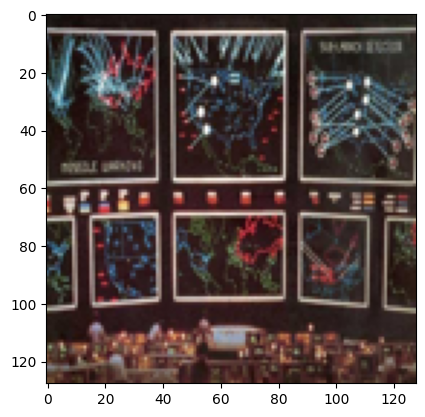

In [46]:
val0 = val_loader.dataset.__getitem__((512,512,2))["samples"]

plt.imshow(np.transpose(val0.cpu().numpy(), (1, 2, 0)))
